In [1]:
# import packages
import numpy as np
import seaborn as sns
from scipy.stats import wishart, dirichlet, expon, norm
import scipy.special as sc
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import dirichlet
import json # to save result

In [2]:
def para_x(u, s2, tao):
    lambdax = np.dot(s2.T, u).reshape(d,d)
    sx = np.linalg.inv(lambdax) # variance of x
    taox = np.dot(tao.T, u) # sum_j(u_j * tao_j)
    mux = np.dot(sx, taox) # mu(x)
    return sx, mux 
def document_generator(a, rho, T, s2, tao, N):
    '''
    Given the corpus, generate more documents.
    All corpus-level parameters are given.
    N: the number of documents.
    
    output: 
    X: N*d, X[i] = document[i]
    Y: Y[i] = label[i]
    G: membership
    U: transformed membership
    '''

    nlabel = len(T) # number of y
    d = len(tao[0]) # dim(x)
    
    Y = np.random.choice(list(range(nlabel)),N) # labels
    G = np.random.dirichlet(a*rho,N)
    U = np.array([np.dot(T[Y[i]], G[i]) for i in range(N)])

    X = []
    
    for i in range(N):
        sx, mux = para_x(U[i], s2, tao)
        X.append(np.random.multivariate_normal(mux, sx))
    X = np.array(X)

    return X, Y, G, U

def check_p(a, rho, mu, s_inv):
    '''
    Input: the parameters used in the data
    1. Check whether a and rho will generate extremely small g
    2. See distributions of different topics
    '''
    ntopic = len(mu)
    g = np.random.dirichlet(a*rho, 100)
#     print("The minimum component of g is",g.min())
    
    print("Distribution of pure types")
    s = [np.linalg.inv(i) for i in s_inv]
    pX = np.concatenate(tuple([np.random.multivariate_normal(mu[i], s[i], 100) for i in range(ntopic)]))
    pY = [[i]*100 for i in range(ntopic)]
    fig_pure_type = plt.figure()
    ax = Axes3D(fig_pure_type)
    ax.scatter(pX[:, 0], pX[:, 1], pX[:, 2], c = pY)
    plt.show()

the value of a: 1.2595527983971346


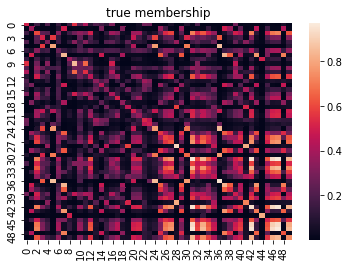

Distribution of pure types


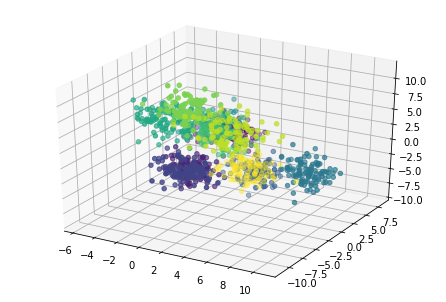

In [5]:
# set parameters
d = 30
k0, k1 = 2,5
nlabel = 3
alpha = np.ones(7)
b = 0.1
para_topic = [np.zeros(d),0.1,np.eye(d)/3/d, 3*d]
N, sigmaa, sigmarho, sigmag, nconverge, nskip, nsave =  50, 1,0.1,0.1,10, 10,500
# define T
dg = k0 + k1 
ntopic = nlabel*k0+k1
T = []
for i in range(nlabel):
    tem = np.block([
        [np.zeros((k0*i,k0+k1))],
        [np.eye(k0), np.zeros((k0, k1))],
        [np.zeros((k0*(nlabel-i-1),k0+k1))],
        [np.zeros((k1,k0)), np.eye(k1)]
    ])
    T.append(tem)
# draw corpus-level parameters
rho = np.random.dirichlet(alpha, 1)[0]
a = np.random.exponential(1/b,1)[0]

mu0, lambda0, W, nu = para_topic
d = len(mu0)
s_inv = wishart.rvs(df = nu, scale = W, size=ntopic) # sigma inverse
mu = np.array([np.random.multivariate_normal(mu0, 1/lambda0*np.linalg.inv(i)) for i in s_inv])    
s2 = np.array([i.flatten() for i in s_inv]) # flatten s_inv, s2[i].reshape(d,d) = s_inv[i]
tao = np.array([np.dot(s_inv[i], mu[i]) for i in range(ntopic)]) # sigma^-1 mu    
# generate data
X, Y, G, U = document_generator(a, rho, T, s2, tao, N)
print("the value of a:", a)
trueU = sns.heatmap(np.dot(U,U.T))
plt.title("true membership")
plt.show()
check_p(a, rho, mu, s_inv)

In [6]:
def simplex_proposal(g, sigma):
    '''
    g is in simplex
    z[i] = log g[i]/g[-1]
    draw newz~N(z, sigma*I)
    newz -> newg
    '''
    z = np.log(g[:-1]/g[-1])
    newz = np.random.multivariate_normal(z, sigma*np.eye(len(z)))
    newg = np.exp(np.append(newz,0))
    newg /= newg.sum()
    return newg

def px(x, u, s2, tao):
    # return 0.5*log|lambda_x|-0.5(x-mux)^T*lambda_x*(x-mux)
    
    lambdax = np.dot(s2.T, u).reshape(d,d)
    sx = np.linalg.inv(lambdax) # variance of x
    taox = np.dot(tao.T, u) # sum_j(u_j * tao_j)
    mux = np.dot(sx, taox) # mu(x)
    
    return 0.5*np.log(np.linalg.det(lambdax))-0.5*np.dot(np.dot((x-mux).T, lambdax), x-mux)

In [7]:
def gibbs(X, Y, alpha, b, T, s2, tao, sigmaa, sigmarho, sigmag, nconverge, nskip, nsave,rho_1,rho_2,a_1, a_2):
#     gibbs(X, Y, alpha, b, T, s2, tao, sigmaa, sigmarho, sigmag, 10, nskip, nsave,rho_1,rho_2,a_1, a_2)
    '''
    rho: mle, mean, on ac rate
    a: mle, sampling, has ac rate
    '''
        
    nlabel = len(T)
    dg = len(alpha)
    ntopic = len(T[0])
    d = len(X[0])
    N = len(Y)  
    
    infinity = 10**(-5) # To avoid overflow, if we get g or rho smaller than this
    
    
    # initialization
    rho1 = np.random.dirichlet(np.ones(dg), 1)[0]
    G1 = np.random.dirichlet(np.ones(dg), N)
    a1 = np.random.exponential(1/b,1)[0]    
#     a1 = a
    probx = [px(X[i], np.dot(T[Y[i]], G1[i]), s2, tao) for i in range(N)]
    
    asave, Gs, rhos, ara, arG, arrho = [], [], [], [], [], [] # estimates and accept rates
    ca = cg = crho = 0 # count of accepted proposals
    
    for step in range(nconverge//nskip):
        ca = cg = crho = 0
        
        for t in range(nskip):
        # update G
            for i in range(N):
                oldg = G1[i]
                newg = simplex_proposal(oldg, sigmag)
                if newg.min()<infinity: newg = (newg + infinity*np.ones(dg))/(1+infinity)
                newpx = px(X[i], np.dot(T[Y[i]], newg), s2, tao)
                oldp = ((a1*rho1-1)*np.log(oldg)).sum() + probx[i]
                newp = ((a1*rho1-1)*np.log(newg)).sum() + newpx
                ag = min(1, np.exp(min(1,newp-oldp))) # avoid overflow when newp>>oldp
                if np.random.uniform() < ag:
                    G1[i] = newg # update G
                    probx[i] = newpx # update px
                    cg += 1
        
            es = dirichlet.mle(G1)
            logG = np.log(G1).sum(axis = 0)
            if rho_1 == "mean":
                rho1 = rho1 = G1.sum(axis=0)/N  
            elif rho_1 == "mle":
                rho1 = es/es.sum()
            if a_1 == "sampling":
                newa = np.random.normal(a1, sigmaa)
                while newa<0: newa = np.random.normal(a1, sigmaa) # truncated Gaussian N(a, sigmaa)
                newp = -b*newa + N*sc.loggamma(newa) - N*(sc.loggamma(newa*rho1)).sum() + ((newa*rho1-1)*logG).sum()
                oldp = -b*a1 + N*sc.loggamma(a1) - N*(sc.loggamma(a1*rho1)).sum() + ((a1*rho1-1)*logG).sum()
                aa = min(1, np.exp(min(1,newp-oldp+np.log((1-norm.cdf(0,newa,sigmaa))/(1-norm.cdf(0,a1,sigmaa))))))
                if np.random.uniform() < aa:
                    a1 = newa
                    ca += 1   
            elif a_1 == "mle":
                a1 = es.sum() 

        Gs.append(G1.copy())
        arG.append(cg/nskip/N)  
        rhos.append(rho1.copy())
        arrho.append(crho/nskip)
        asave.append(a1)
        ara.append(ca/nskip)
    
    
    for step in range(nsave):
        ca = cg = crho = 0
        
        for t in range(nskip):
        # update G
            for i in range(N):
                oldg = G1[i]
                newg = simplex_proposal(oldg, sigmag)
                if newg.min()<infinity: newg = (newg + infinity*np.ones(dg))/(1+infinity)
                newpx = px(X[i], np.dot(T[Y[i]], newg), s2, tao)
                oldp = ((a1*rho1-1)*np.log(oldg)).sum() + probx[i]
                newp = ((a1*rho1-1)*np.log(newg)).sum() + newpx
                ag = min(1, np.exp(min(1,newp-oldp))) # avoid overflow when newp>>oldp
                if np.random.uniform() < ag:
                    G1[i] = newg # update G
                    probx[i] = newpx # update px
                    cg += 1
        
            es = dirichlet.mle(G1)
            logG = np.log(G1).sum(axis = 0)
            if rho_2 == "mean":
                rho1 = G1.sum(axis=0)/N  
            elif rho_2 == "mle":
                rho1 = es/es.sum()
            if a_2 == "sampling":
                newa = np.random.normal(a1, sigmaa)
                while newa<0: newa = np.random.normal(a1, sigmaa) # truncated Gaussian N(a, sigmaa)
                newp = -b*newa + N*sc.loggamma(newa) - N*(sc.loggamma(newa*rho1)).sum() + ((newa*rho1-1)*logG).sum()
                oldp = -b*a1 + N*sc.loggamma(a1) - N*(sc.loggamma(a1*rho1)).sum() + ((a1*rho1-1)*logG).sum()
                aa = min(1, np.exp(min(1,newp-oldp+np.log((1-norm.cdf(0,newa,sigmaa))/(1-norm.cdf(0,a1,sigmaa))))))
                if np.random.uniform() < aa:
                    a1 = newa
                    ca += 1   
            elif a_2 == "mle":
                a1 = es.sum() 

        Gs.append(G1.copy())
        arG.append(cg/nskip/N)  
        rhos.append(rho1.copy())
        arrho.append(crho/nskip)
        asave.append(a1)
        ara.append(ca/nskip)
    return np.array(asave), np.array(Gs), np.array(rhos), np.array(ara), np.array(arG), np.array(arrho)

def tuningp(sigmaa=0.1, sigmarho=0.1, sigmag=0.1, nconverge=10, nskip=10, nsave=10,a=0,rho_1="mean",rho_2="mean",a_1="sampling", a_2="sampling"):
    asave, Gs, rhos, ara, arG, arrho = gibbs(X, Y, alpha, b, T, s2, tao, sigmaa, sigmarho, sigmag, nconverge, nskip, nsave,rho_1,rho_2,a_1, a_2)
    print("accept rate of a, G for the last iteration:",arG[-1])
    G1 = Gs[-1]
    N = len(X)
    print("ave error G:", (abs(G-G1)).sum()/N)
    print("error rho:", abs(rhos[-1]-rho).sum())
    print("error a:", asave[-1]-a)
    # Summary G
    differenceG = abs(G-G1).sum(axis=1)
    error_summary_G = []
    print("\n")
    for tt in range(5,0,-1):
        tem = tt/10
        error_summary_G.append(sum([1 for i in range(N) if differenceG[i]<tem])/N)
        print("P(difference<"+str(tem)+")=", error_summary_G[-1])

    eU = sns.heatmap(np.dot(G1,G1.T))
    plt.title("estimated membership")
    plt.show()
    
    # error G
    errorG = abs(Gs - G).sum(axis=1).sum(axis=1)/N
    plt.scatter([i*nskip for i in range(len(errorG))], errorG, s=5)
    plt.title("estimation error of G")
    plt.xlabel("t")
    plt.ylabel("error")
    plt.show()
    # ar G
    plt.scatter([i*nskip for i in range(len(arG))], arG, s=5)
    plt.title("acc rate of G")
    plt.xlabel("t")
    plt.ylabel("error")
    plt.show()
    # error rho
    errorrho = abs(rhos - rho).sum(axis=1)
    plt.scatter([i*nskip for i in range(len(errorrho))], errorrho, s=5)
    plt.title("estimation error of rho")
    plt.xlabel("t")
    plt.ylabel("error")
    plt.show()
    # error a
    errora = asave - a
    plt.scatter([i*nskip for i in range(len(errora))], errora, s=5)
    plt.title("estimation error of a")
    plt.xlabel("t")
    plt.ylabel("error")
    plt.show()
    # ar a
    if a_2 == 'sampling':
        plt.scatter([i*nskip for i in range(len(ara))], ara, s=5)
        plt.title("acc rate of a")
        plt.xlabel("t")
        plt.ylabel("error")
        plt.show()

    return asave, Gs, rhos, ara, arG, arrho
# test
# asave, Gs, rhos, ara, arG, arrho = tuningp(sigmaa=0.1, sigmarho=0.1, sigmag=0.1, nconverge=100, nskip=10, nsave=10,a=0,rho_1="mean",rho_2="mean",a_1="mle", a_2="mle")

----------------------------------------------------------------------------------------------------
rho_1, rho_2, a_1, a_2 = mean, mean, mle, mle	
accept rate of a, G for the last iteration: 0.726
ave error G: 0.32891150246537804
error rho: 0.14303313691611325
error a: -0.33787944302654127


P(difference<0.5)= 0.78
P(difference<0.4)= 0.72
P(difference<0.3)= 0.62
P(difference<0.2)= 0.42
P(difference<0.1)= 0.18


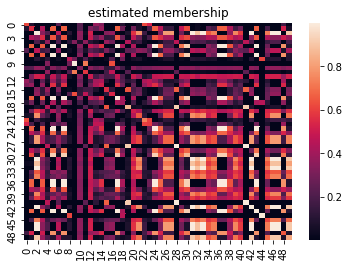

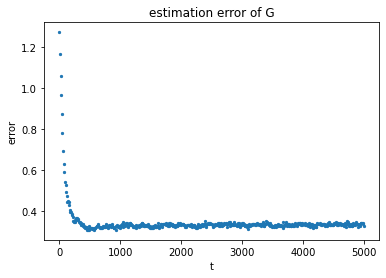

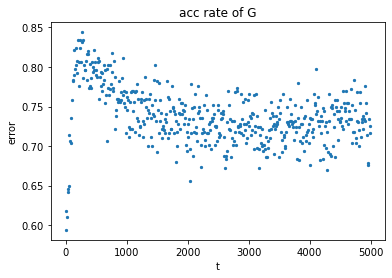

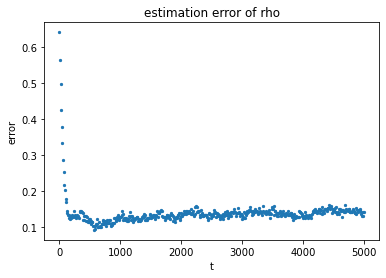

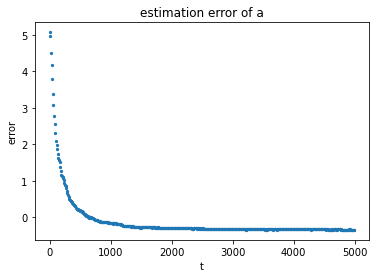

----------------------------------------------------------------------------------------------------
rho_1, rho_2, a_1, a_2 = mean, mean, mle, sampling	
accept rate of a, G for the last iteration: 0.722
ave error G: 0.33790003083659803
error rho: 0.2243439732795053
error a: -0.021932677046594184


P(difference<0.5)= 0.8
P(difference<0.4)= 0.72
P(difference<0.3)= 0.64
P(difference<0.2)= 0.48
P(difference<0.1)= 0.24


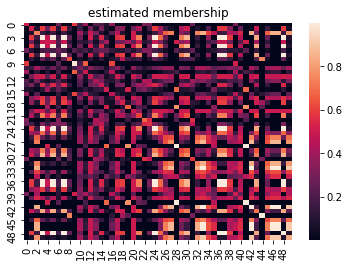

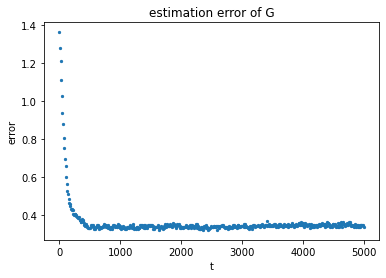

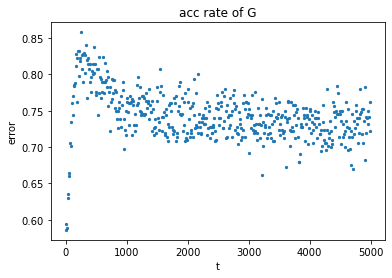

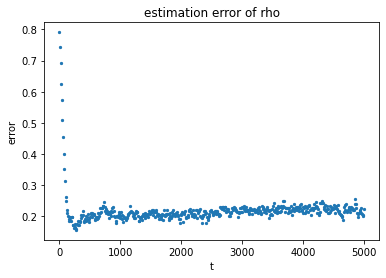

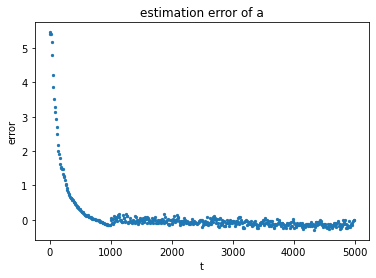

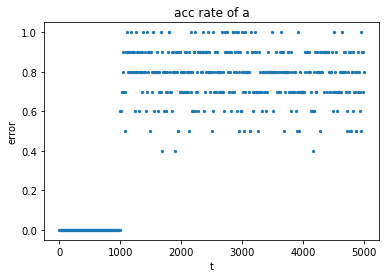

----------------------------------------------------------------------------------------------------
rho_1, rho_2, a_1, a_2 = mean, mean, sampling, mle	
accept rate of a, G for the last iteration: 0.758
ave error G: 0.34906395808005336
error rho: 0.1080373273017869
error a: -0.3065081648457054


P(difference<0.5)= 0.8
P(difference<0.4)= 0.72
P(difference<0.3)= 0.62
P(difference<0.2)= 0.4
P(difference<0.1)= 0.18


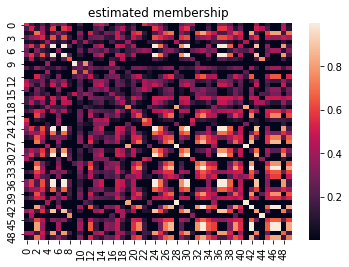

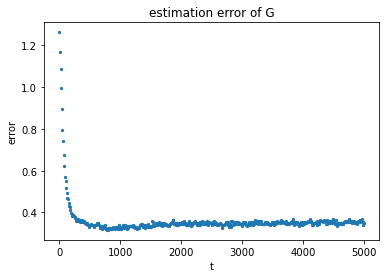

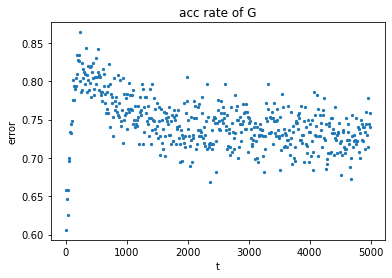

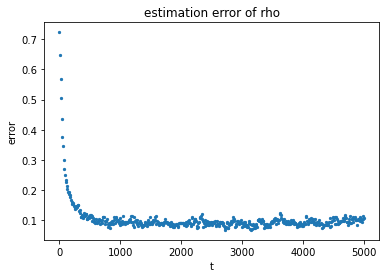

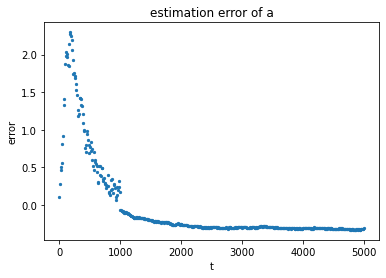

----------------------------------------------------------------------------------------------------
rho_1, rho_2, a_1, a_2 = mean, mean, sampling, sampling	
accept rate of a, G for the last iteration: 0.7340000000000001
ave error G: 0.2639993837478476
error rho: 0.1591763758104166
error a: -0.08863743435973737


P(difference<0.5)= 0.86
P(difference<0.4)= 0.78
P(difference<0.3)= 0.74
P(difference<0.2)= 0.46
P(difference<0.1)= 0.24


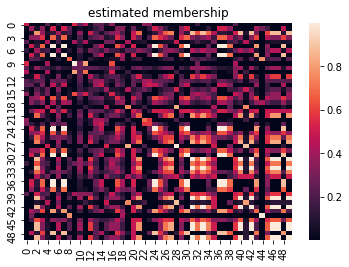

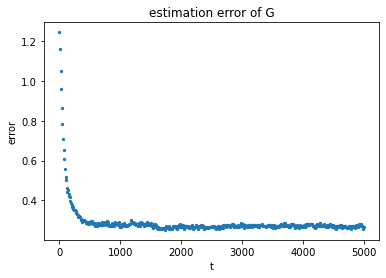

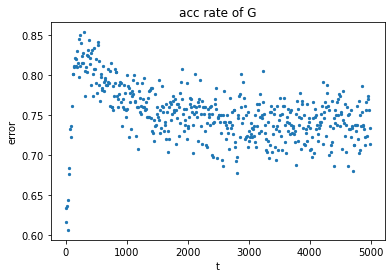

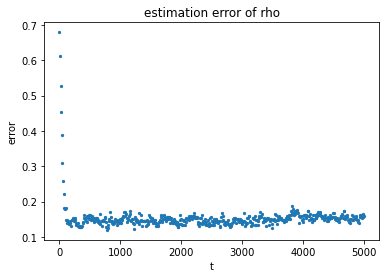

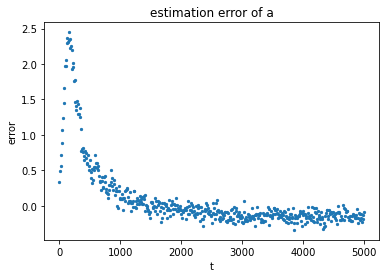

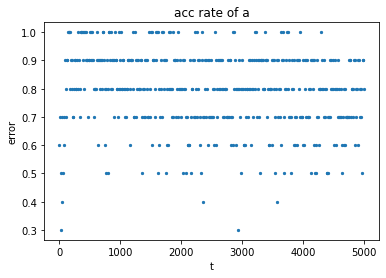

----------------------------------------------------------------------------------------------------
rho_1, rho_2, a_1, a_2 = mean, mle, mle, mle	
accept rate of a, G for the last iteration: 0.738
ave error G: 0.3179470457303183
error rho: 0.44369042457740065
error a: -0.31046160437462833


P(difference<0.5)= 0.78
P(difference<0.4)= 0.74
P(difference<0.3)= 0.64
P(difference<0.2)= 0.46
P(difference<0.1)= 0.24


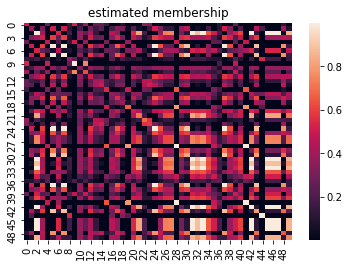

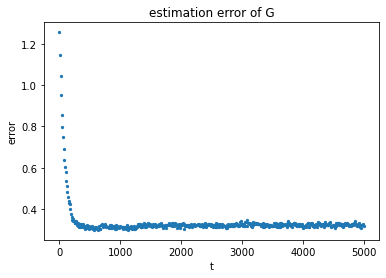

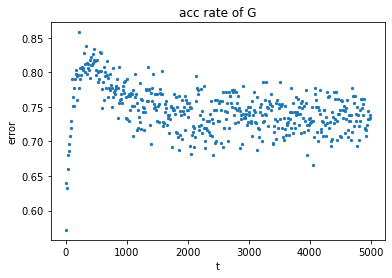

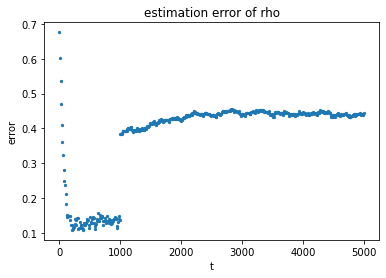

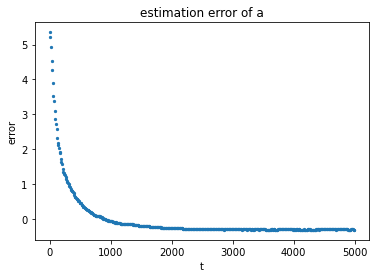

----------------------------------------------------------------------------------------------------
rho_1, rho_2, a_1, a_2 = mean, mle, mle, sampling	
accept rate of a, G for the last iteration: 0.728
ave error G: 0.26714385993571044
error rho: 0.476370102206618
error a: -0.42882753076253677


P(difference<0.5)= 0.88
P(difference<0.4)= 0.82
P(difference<0.3)= 0.72
P(difference<0.2)= 0.48
P(difference<0.1)= 0.22


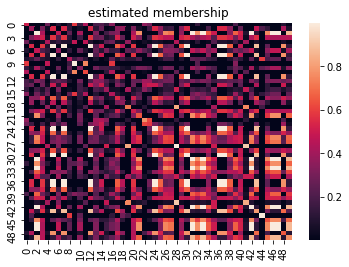

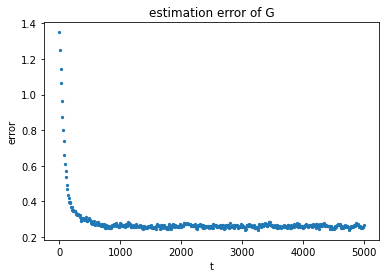

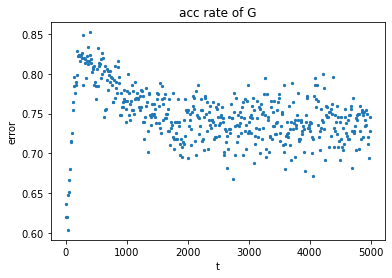

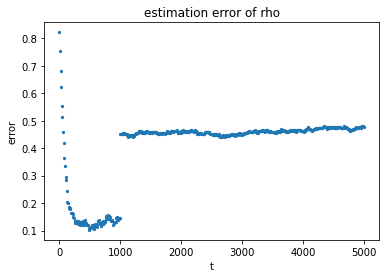

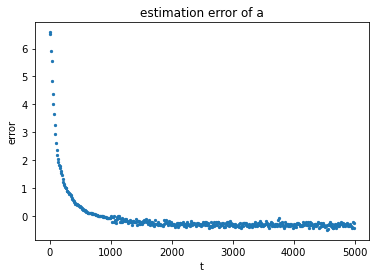

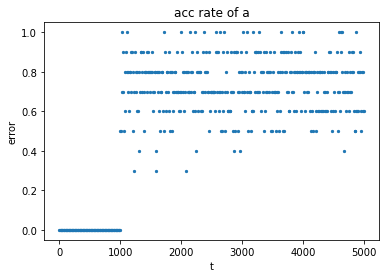

----------------------------------------------------------------------------------------------------
rho_1, rho_2, a_1, a_2 = mean, mle, sampling, mle	
accept rate of a, G for the last iteration: 0.6920000000000001
ave error G: 0.2819149793968096
error rho: 0.416638783016799
error a: -0.2892605936889818


P(difference<0.5)= 0.8
P(difference<0.4)= 0.74
P(difference<0.3)= 0.66
P(difference<0.2)= 0.44
P(difference<0.1)= 0.24


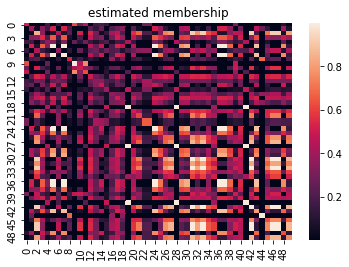

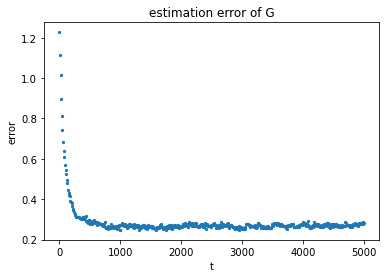

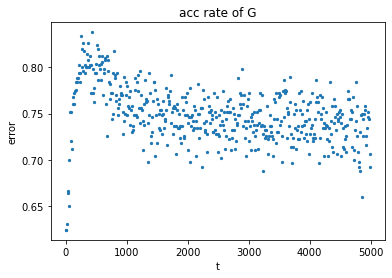

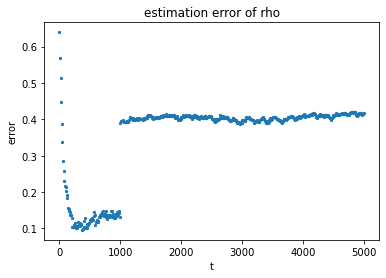

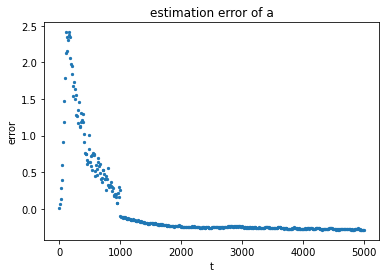

----------------------------------------------------------------------------------------------------
rho_1, rho_2, a_1, a_2 = mean, mle, sampling, sampling	
accept rate of a, G for the last iteration: 0.696
ave error G: 0.2503294739471729
error rho: 0.4424190512030296
error a: -0.303568056601207


P(difference<0.5)= 0.86
P(difference<0.4)= 0.8
P(difference<0.3)= 0.7
P(difference<0.2)= 0.52
P(difference<0.1)= 0.24


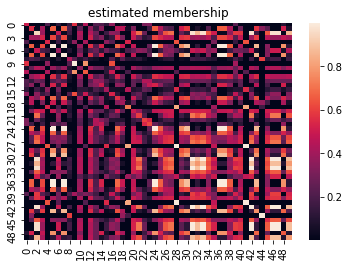

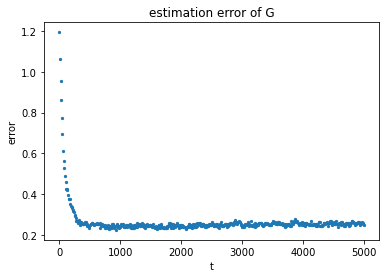

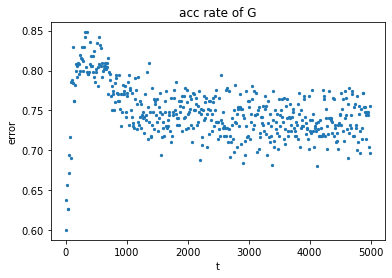

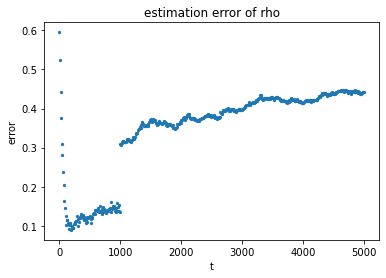

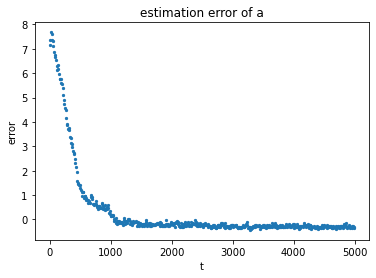

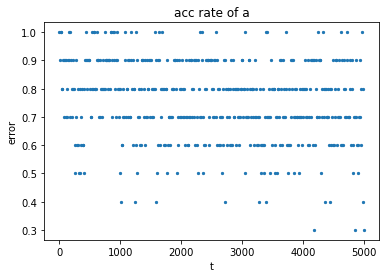

----------------------------------------------------------------------------------------------------
rho_1, rho_2, a_1, a_2 = mle, mean, mle, mle	
accept rate of a, G for the last iteration: 0.7140000000000001
ave error G: 0.28458511846990014
error rho: 0.1460656075024495
error a: -0.31952295231999006


P(difference<0.5)= 0.88
P(difference<0.4)= 0.74
P(difference<0.3)= 0.66
P(difference<0.2)= 0.5
P(difference<0.1)= 0.22


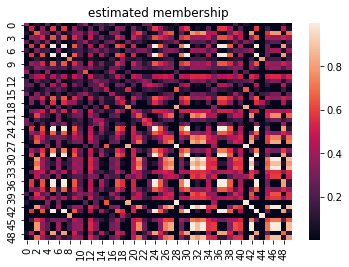

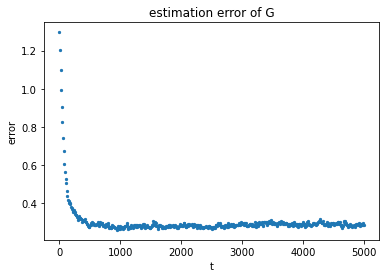

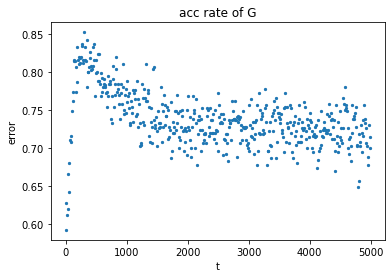

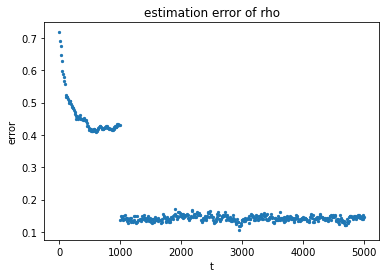

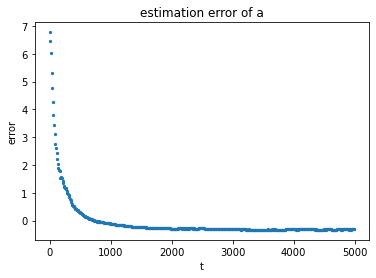

----------------------------------------------------------------------------------------------------
rho_1, rho_2, a_1, a_2 = mle, mean, mle, sampling	
accept rate of a, G for the last iteration: 0.708
ave error G: 0.2849187822938208
error rho: 0.13220496551822356
error a: -0.15559187988778422


P(difference<0.5)= 0.8
P(difference<0.4)= 0.74
P(difference<0.3)= 0.66
P(difference<0.2)= 0.44
P(difference<0.1)= 0.22


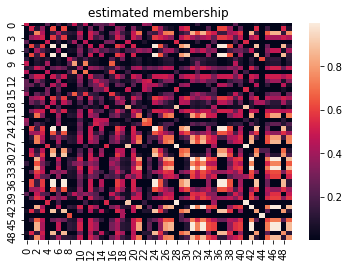

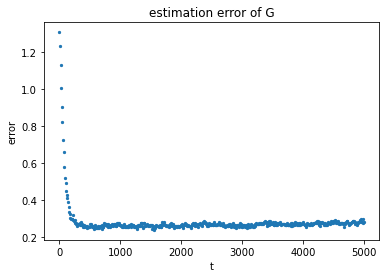

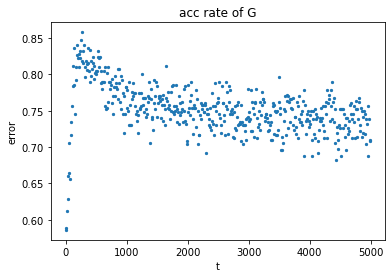

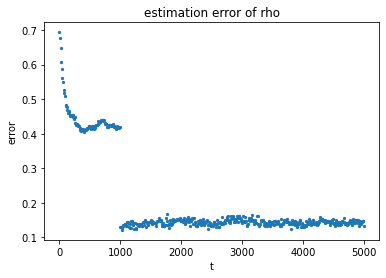

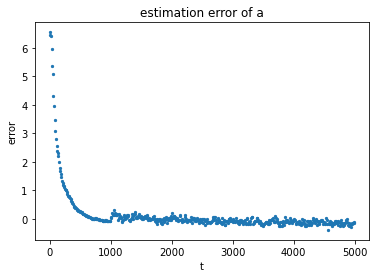

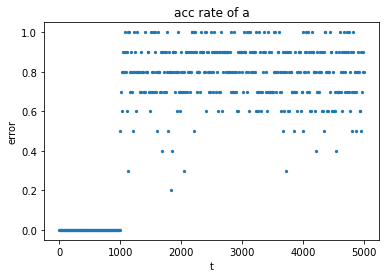

----------------------------------------------------------------------------------------------------
rho_1, rho_2, a_1, a_2 = mle, mean, sampling, mle	
accept rate of a, G for the last iteration: 0.698
ave error G: 0.29049683495738116
error rho: 0.1517807582195443
error a: -0.28495131330611834


P(difference<0.5)= 0.88
P(difference<0.4)= 0.78
P(difference<0.3)= 0.68
P(difference<0.2)= 0.46
P(difference<0.1)= 0.2


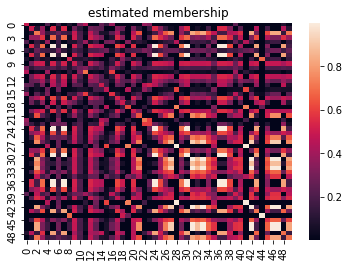

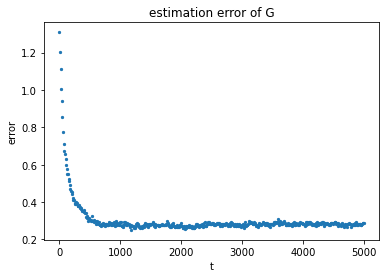

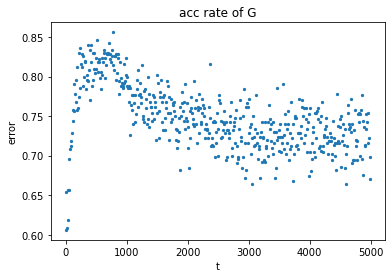

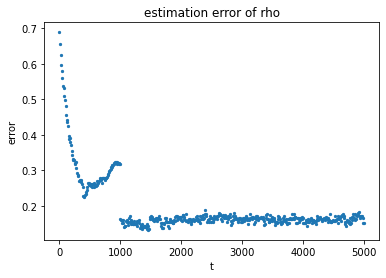

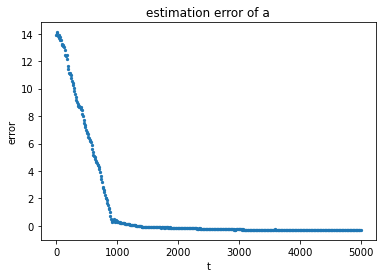

----------------------------------------------------------------------------------------------------
rho_1, rho_2, a_1, a_2 = mle, mean, sampling, sampling	
accept rate of a, G for the last iteration: 0.73
ave error G: 0.2673813733182001
error rho: 0.14866134144236748
error a: -0.10276829624935391


P(difference<0.5)= 0.88
P(difference<0.4)= 0.8
P(difference<0.3)= 0.7
P(difference<0.2)= 0.5
P(difference<0.1)= 0.2


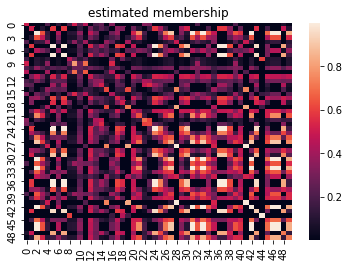

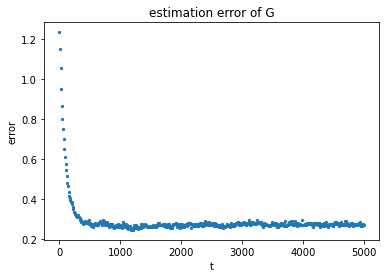

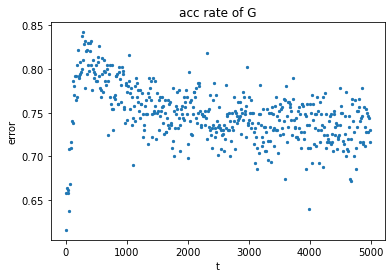

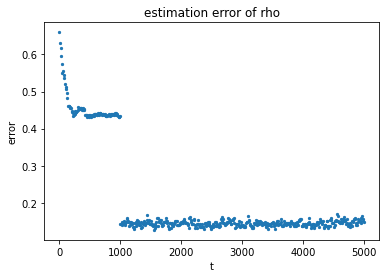

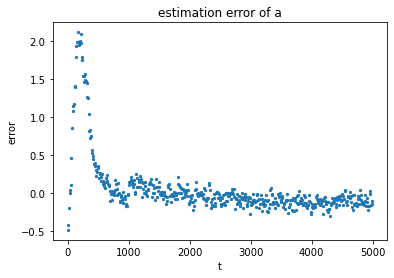

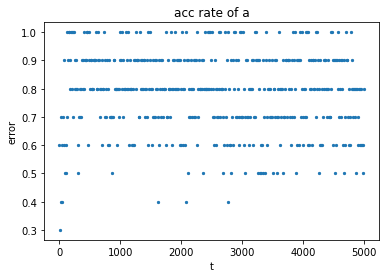

----------------------------------------------------------------------------------------------------
rho_1, rho_2, a_1, a_2 = mle, mle, mle, mle	
accept rate of a, G for the last iteration: 0.7240000000000001
ave error G: 0.33163689858647755
error rho: 0.45583429202217735
error a: -0.3329939501453586


P(difference<0.5)= 0.82
P(difference<0.4)= 0.74
P(difference<0.3)= 0.66
P(difference<0.2)= 0.46
P(difference<0.1)= 0.28


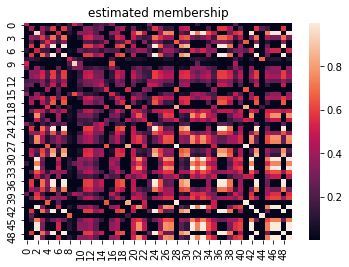

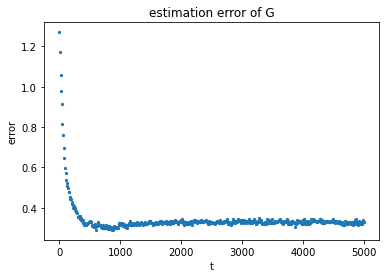

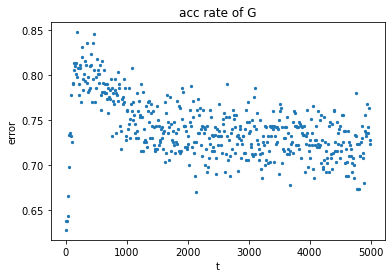

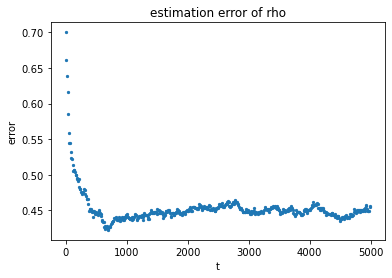

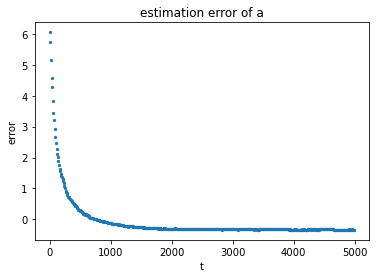

----------------------------------------------------------------------------------------------------
rho_1, rho_2, a_1, a_2 = mle, mle, mle, sampling	
accept rate of a, G for the last iteration: 0.72
ave error G: 0.24386976206427097
error rho: 0.4904877920169887
error a: -0.46198103108332256


P(difference<0.5)= 0.88
P(difference<0.4)= 0.8
P(difference<0.3)= 0.7
P(difference<0.2)= 0.5
P(difference<0.1)= 0.24


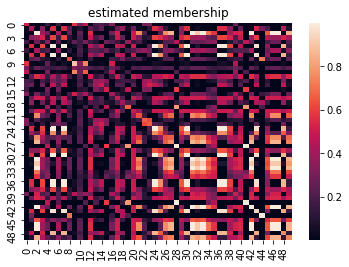

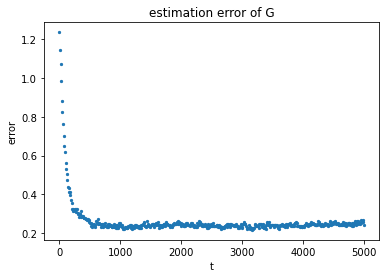

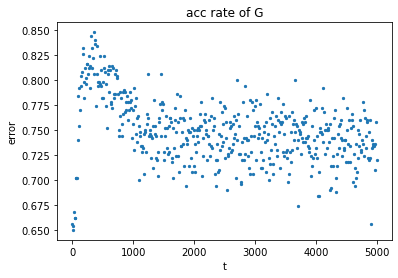

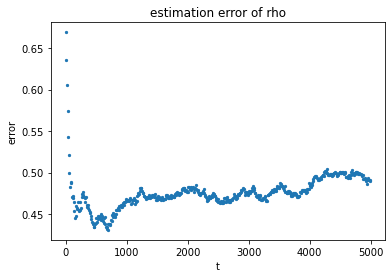

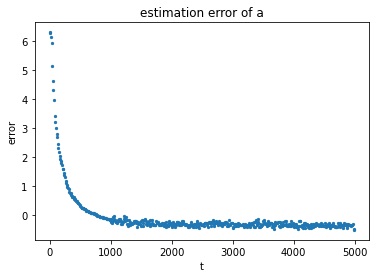

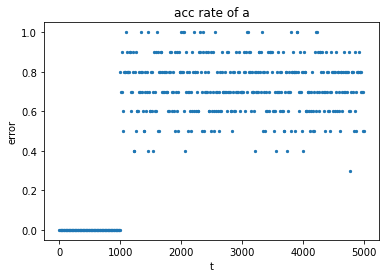

----------------------------------------------------------------------------------------------------
rho_1, rho_2, a_1, a_2 = mle, mle, sampling, mle	
accept rate of a, G for the last iteration: 0.738
ave error G: 0.23769117432119202
error rho: 0.4147869384846492
error a: -0.28471420539422665


P(difference<0.5)= 0.88
P(difference<0.4)= 0.82
P(difference<0.3)= 0.74
P(difference<0.2)= 0.48
P(difference<0.1)= 0.24


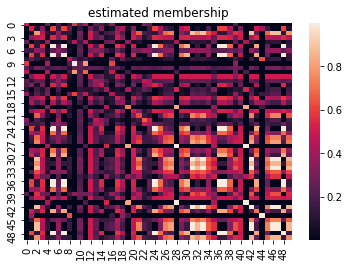

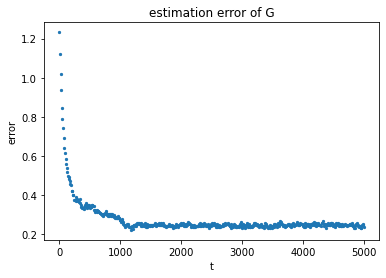

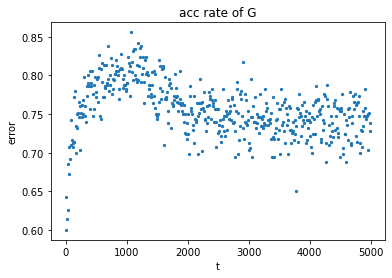

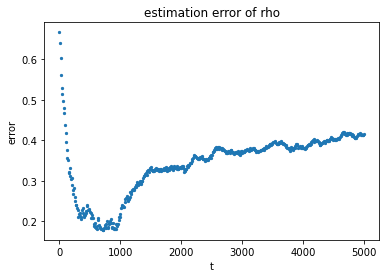

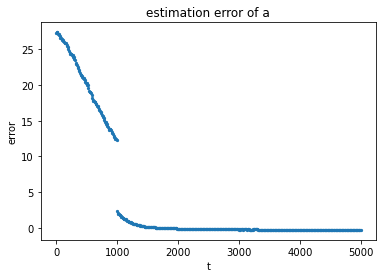

----------------------------------------------------------------------------------------------------
rho_1, rho_2, a_1, a_2 = mle, mle, sampling, sampling	
accept rate of a, G for the last iteration: 0.738
ave error G: 0.23269138701673633
error rho: 0.4769906981975679
error a: -0.37454802843171964


P(difference<0.5)= 0.92
P(difference<0.4)= 0.82
P(difference<0.3)= 0.78
P(difference<0.2)= 0.54
P(difference<0.1)= 0.22


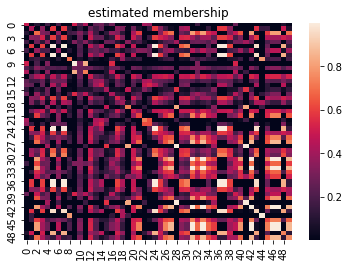

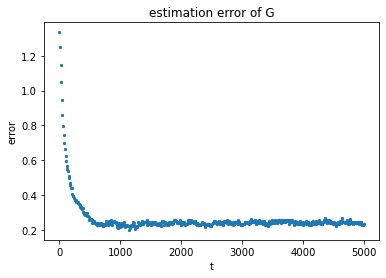

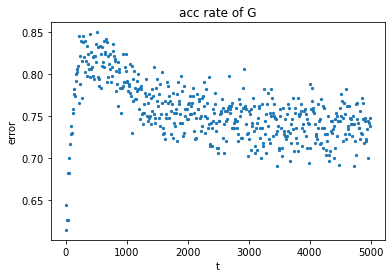

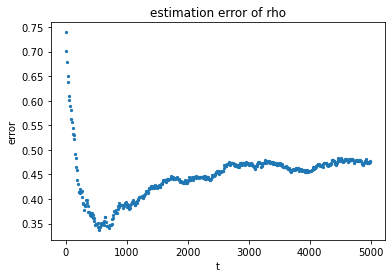

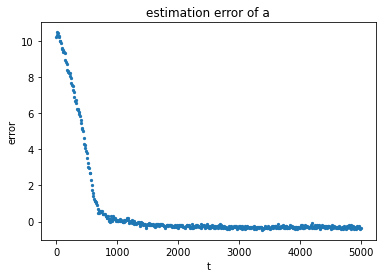

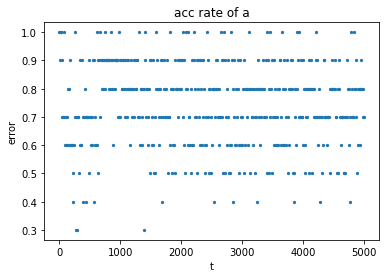

In [8]:
res = []
for i1 in ["mean", "mle"]:
    for i2 in ["mean", "mle"]:
        for j1 in ["mle", 'sampling']:
            for j2 in ["mle", 'sampling']:
                print("\033[31m%s\033[0m"%("-"*100))
                print("\033[37;41mrho_1, rho_2, a_1, a_2 = %s, %s, %s, %s\t\033[0m"%(i1,i2,j1,j2))
                res.append(tuningp(sigmaa=0.05, sigmarho=0.1, sigmag=0.01, nconverge=1000, nskip=10, nsave=400,a=a,rho_1=i1,rho_2=i2,a_1=j1, a_2=j2))

In [9]:
print(a)

1.2595527983971346


In [11]:
np.save("./data2/rho.npy", rho)

In [12]:
np.save("./data2/X.npy", X)
np.save("./data2/Y.npy", Y)
np.save("./data2/G.npy", G)
np.save("./data2/mu.npy", mu)
np.save("./data2/s_inv.npy", s_inv)

In [153]:
# np.load("./data2/X.npy")c

In [13]:
# save estimate of a
tema = []
for i in range(16):
    tema.append(res[i][0])
tema = np.array(tema)
# tema[i] is the estimate of a in experiment i
np.save("./data2/estimate_of_a.npy", tema)

In [14]:
temg = []
for i in range(16):
    temg.append(res[i][1])
temg = np.array(temg)
# print(temg.shape)
np.save("./data2/estimate_of_G.npy", temg)
# print(temg[0][0][0][0])
# print(np.load("./data2/estimate_of_G.npy")[0][0][0][0])

In [15]:
temrho = []
for i in range(16):
    temrho.append(res[i][2])
temrho = np.array(temrho)
# print(temrho.shape)
np.save("./data2/estimate_of_rho.npy", temrho)
# print(temrho[0][0][0])
# print(np.load("./data2/estimate_of_rho.npy")[0][0][0])

In [ ]:
# res[i]: res of experiment i
# res[i][j=0,...5] asave, Gs, rhos, ara, arG, arrho
# res[i][j][0,...,500]